
<h1>Scikit-Learn</h1>

Ce devoir s'appuie sur la mission évoquée en cours : vous avez deux fichiers dont chaque ligne représente un internaute :<br>
1) X : une colonne par page web, et le nombre de visites de l'internaute<br>
2) Y : des informations sur l'internaute : âge / sexe / âge bucketisé 

On demande de prévoir la tranche d'âge et le sexe en s'appuyant sur les innformations de pages vues. <br>
Le notebook ci-après est un début de réponse à cette question. <br><br>
<b>En partant de cette base il vous est demandé les 5 choses suivantes :</b>
        
1) Commentez le code avec des docstring multilignes en respectant la norme décrite ici : https://www.python.org/dev/peps/pep-0257/ <br>
2) Rajoutez dans le code un calcul et affichage de temps d'éxécution des fonctions de search grid (utilisez <a href=https://docs.python.org/2/library/time.html> time</a> ou ctime). Les temps d'éxécutions sont ils acceptables en conditions réels ?  (Faites varier nb_lignes )<br>
3) Ajoutez la fonction knn aux fonctions SVM et RF déjà testées ci-dessous<br>
4) Choisissez un algorithme dans <a href=http://scikit-learn.org/stable>scikit-learn</a>, créez-lui une fonction de search-grid et appliquez le sur X, Y, pour la question de l'âge et celle du sexe. Affichez des scores, matrices de confusion, courbes ROC, temps d'éxécution...<br>
5) Commentez les résultats des différents algorithmes<br>

Vous rendrez votre notebook comme rapport (format normal : .ipynb) via un email avec comme sujet : <br>
<b>ESILV - devoir scikit-learn - NOM EN MAJUSCULE Prénom <br></b>
Devoir individuel, tout plagiat sera sanctionné.
    

# -1) Imports

In [5]:
""" Importation des différents modules utile ici Pandas, os, sys, itertools et numpy"""

import pandas as pd
import os
import sys
import numpy as np
import itertools

""" Importation des fonctions datatime, defaultimpact et matplotlib """
from datetime import datetime
from collections import defaultdict

%matplotlib inline

In [6]:
""" Importation des fonctions stats, pylab et plot"""

import scipy.stats as stats
import pylab
import matplotlib.pyplot as plot

# 0) useful functions

In [7]:
"""Fonction qui permet d'afficher l'heure, les minutes et les secondes du moment de lancement de la fonction""" 

def print_time():
    import time
    import datetime
    t = datetime.datetime.now().time()
    print t.isoformat()[:8]
    return time.time()
    
    #A modifier: Temps Calc

In [8]:
"""Fonction qui trace une matrice de confusion"""
def draw_confusion_matrix(y_test, predictions, title):
    from sklearn.metrics import confusion_matrix,accuracy_score
    import matplotlib.pyplot as plt
    cm    = confusion_matrix(y_test, predictions)
    accur = accuracy_score  (y_test, predictions)
    
    plt.matshow  (cm)
    plt.ylabel   ('True Label')
    plt.xlabel   ('Predicted Label')
    plt.suptitle ('Confusion matrix (Accuracy of %.2f) for [%s]'%(accur,title))
    plt.colorbar ()
    plt.show     ()

In [ ]:
""" Fonction qui trace une courbe ROC en fonction du modèle choisi et des données x_test et y_test"""

def draw_roc_curve(fitted_c, x_test, y_test, title):
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt
    c                                        = fitted_c
    probas                                   = c.predict_proba(x_test)
    false_positive_rate, recall_, thresholds = roc_curve(y_test, probas[:,1])
    roc_auc                                  = auc(false_positive_rate, recall_)
    
    plt.title  ('ROC %.2f %s'%(roc_auc, title))
    plt.legend (loc="lower right")
    plt.plot   ([0,1],[0,1], "r--")
    plt.plot   (false_positive_rate, recall_, 'b', label='AUC = %.2f'%roc_auc)
    plt.xlim   ([0.0,1.1])
    plt.ylim   ([0.0,1.1])
    plt.ylabel ('Recall')
    plt.xlabel ('Fall-out')
    plt.show()

# 1) Chargement des données


In [ ]:
"""Chargement du fichier csv: base_x"""
X = pd.read_csv("Archive\\base_x.csv", index_col=0)

In [ ]:
"""Chargement du fichier csv base_y"""
Y = pd.read_csv("Archive\\base_y.csv", index_col=0)

In [86]:
""" Modification de la forme de la variable Y.shape"""
assert(sum(Y.index == X.index) == Y.shape[0])

# 1) first checks

In [9]:
""" Description global de la donnée: Calcul des moyennes, ecart-type, décile et quartiles  """

for data in [Y]:
    title = "Number of rows and columns"
    print "% 35s : %s rows, %s columns "%(title, data.shape[0], data.shape[1])
    title = "Number of categorical variables"
    print "% 35s : 1 variable, and 10 modalities"%title
    title = "Number of values by modality" 
    print "% 35s :"% (title)
    t = data.bucket.value_counts()
    t = t.sort_index()
    for x,y in t.iteritems():
        print "% 37s % 9s % 5s"%("", x,y)

    title = "Moyenne des âges"
    print "% 35s : %.1f"%(title, data.age.mean())
    title = "Ecart type"
    print "% 35s : %.1f"%(title,data.age.std())

    quartiles = {}
    for i in range(5):
        quartiles[i] = np.percentile(data.age, i*100/4)

    title = "Frontière des Quartiles"
    print "% 35s : %s"%(title, " , ".join(["%s"%y for x,y in quartiles.iteritems()]))

    title = "ecartement inter quartile"
    print "% 35s : %s"%(title, " , ".join(["%s"%(quartiles[i]-quartiles[i-1]) for i in range(1,5)]))


    decile = {}
    for i in range(10):
        decile[i] = np.percentile(data.age, i*100/10)
    title = "Frontière des Deciles"
    print "% 35s : %s"%(title, " , ".join(["%s"%y for x,y in decile.iteritems()]))

    title = "ecartement inter decile"
    print "% 35s : %s"%(title, " , ".join(["%s"%(decile[i]-decile[i-1]) for i in range(1,10)]))


         Number of rows and columns : 39045 rows, 7 columns 
    Number of categorical variables : 1 variable, and 10 modalities
       Number of values by modality :
                                       (14, 18]   151
                                       (18, 20]   357
                                       (20, 25]  1734
                                       (25, 30]  4070
                                       (30, 35]  4150
                                       (35, 40]  4702
                                       (40, 45]  4591
                                       (45, 65] 16136
                                       (65, 70]  1743
                                      (70, 150]  1411
                  Moyenne des âges : 45.5
                         Ecart type : 13.6
           Frontière des Quartiles : 18.0 , 35.0 , 45.0 , 55.0 , 95.0
          ecartement inter quartile : 17.0 , 10.0 , 10.0 , 40.0
             Frontière des Deciles : 18.0 , 28.0 , 33.0 , 37.0 , 41.0 , 45

# L'âge est-il normal ?

((array([-4.13494008, -3.92652537, -3.81279465, ...,  3.81279465,
          3.92652537,  4.13494008]),
  array([ 18.,  18.,  18., ...,  94.,  95.,  95.])),
 (13.475733117621841, 45.471046228710456, 0.9929491353419202))

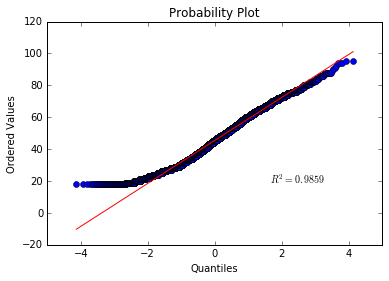

In [10]:
"""Clacul de la variance expliqué sur les données de l'age"""
stats.probplot(Y.age, dist="norm", plot=pylab)


On remarque que la variance expliquée R2 est très proche de 1 cad R^2 = 0.9859.

# 2) binarization des âges

In [11]:
""" On définie dans un tableau une liste des ages """
bins = np.array([13,19,24,29, 34, 39, 44,49,54,59,100])
labels = pd.cut(data.age, bins)
Y['bucketed_age'] = labels

In [12]:
dataSerie = pd.Series(Y.bucketed_age)

In [13]:
dataSerie.sort()
x = dataSerie.value_counts()

C:\Users\Yacine\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting
  if __name__ == '__main__':


In [14]:
x = x.sort_index()

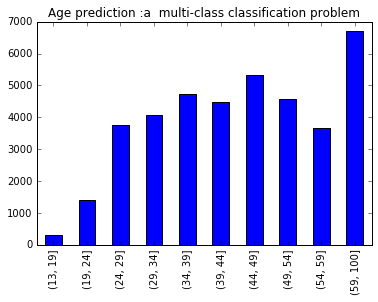

In [15]:
"""On trace un histogramme: repartition du nombre de personnes en fonction de leurs ages"""
title="Age prediction :a  multi-class classification problem"
x.plot(kind="bar", title=title)

# 4) grid search (Les fonctions)

In [16]:
"""  On crée une grid search comprenant une fonction Random Forest"""
def RandomForest_grid_search(df, Y):
    start = print_time() #Définition de la fonction calcul de temps
    """ Importation des packages utile à la grid search"""
    import sys, pickle
    from sklearn.ensemble          import RandomForestClassifier
    from sklearn                   import grid_search
    from sklearn.metrics           import make_scorer
    from sklearn.preprocessing     import label_binarize
    from sklearn.multiclass        import OneVsRestClassifier
    #grid search :
    """ Définition des parametres de la fonction Randoma forest"""
    
    
    parameters = {  "n_estimators"         : [ 10, 100, 200 ], 
                    "min_samples_leaf"     : [  3,   1,   7 ],
                    "criterion"            : ["gini"],#["gini", "entropy"]         ,
                    "max_features"         : ["auto"]      ,
                    "max_depth"            : [None]         , 
                    "n_jobs"               : [ -1]             ,  
                    "class_weight"         : ["auto"]          ,
                    "warm_start"           : [False]           }
    parameters = {  "n_estimators"         : [ 10], 
                    "min_samples_leaf"     : [  3 ],
                    "criterion"            : ["gini"],#["gini", "entropy"]         ,
                    "max_features"         : ["auto"]      ,
                    "max_depth"            : [None]         , 
                    "n_jobs"               : [ -1]             ,  
                    "class_weight"         : ["auto"]          ,
                    "warm_start"           : [False]           }
    
    grid_type = "RandomForestClassifier"
    
    print "-"*30, "\n %s"%grid_type; sys.stdout.flush()
    """
        Search 
    """
    
    """ Appel de la grid_search random forest"""
    grid         = grid_search.GridSearchCV(RandomForestClassifier(), {})#, parameters, verbose=1, scoring='f1_weighted')
    
    try :grid.fit(df, Y)
    except Exception as e : print "[%s - 2] : %s"%(grid_type,e) 
    
    print " best_score_ %s with =  %s "%( grid.best_score_,  grid.best_estimator_ ) ; sys.stdout.flush()   
    
    end = print_time() #Affichage temps fin d'éxécution
    print end - start # Calcul du temps d'éxécution de l'algorithme
    return grid.best_estimator_

In [17]:
""" On crée une grid search comprenant une fonction SVM """
def svm_grid_search(df, Y):
    start = print_time() #Définition de la fonction calcul de temps
    import sys
    from sklearn                   import grid_search
    from sklearn.svm               import SVC
    import pickle
    parameters = {  "C"              : [1.0],#, 0.5, 0.1, 2]                , 
                    "kernel"         : ['rbf'],#, 'poly', 'sigmoid']        ,
                    "degree"         : [2],#, 3, 4,5,6]                     , 
                    "gamma"          : [0.01],#, 0.1, 0.001, 0.5]           , 
                    "coef0"          : [0.0]                             , 
                    "shrinking"      : [True]                            , 
                    "probability"    : [True]                            , 
                    "tol"            : [0.001]                           , 
                    "cache_size"     : [10]                              , 
                    "class_weight"   : [None]                            , 
                    "verbose"        : [False]                           , 
                    "max_iter"       : [-1]                              , 
                    "random_state"   : [None]                            }
   
    
    
    print "-"*30, "\n svm_grid_search"; sys.stdout.flush()
    
    """
        Search Grid
    """
    grid    = grid_search.GridSearchCV(SVC(), parameters, verbose=0, scoring='f1_weighted')
    try :grid.fit(df, Y)
    except Exception as e : print "[svm_grid_search - 2] : %s"%e ; print "x_train, y_train : ", x_train, y_train

    print " best_score_ = %.2f with =  %s "%(grid.best_score_, grid.best_estimator_ ) ; sys.stdout.flush() 
    end = print_time() #Affichage temps fin d'éxécution
    print end - start # Calcul du temps d'éxécution de l'algorithme
    return grid.best_estimator_

In [79]:
"""  On crée une grid search comprenant une fonction KNN"""
def knn_grid_search(df, Y):
    start = print_time() #Définition de la fonction calcul de temps
    import sys
    from sklearn import grid_search
    from sklearn.neighbors import KNeighborsClassifier
    import pickle
    parameters = { "n_neighbors" : [2, 3, 5, 8 , 10] , 
     "weights" : ['uniform', 'distance'] ,
     "algorithm" : ['auto', 'ball_tree', 'kd_tree', 'brute'] , 
     "leaf_size" : [1,3 ] }

    grid_type = "knn_grid_search"
    print "-"*30, "\n %s"%grid_type; sys.stdout.flush()
    """
    Search Grid
    """
    print parameters;sys.stdout.flush()
    grid = grid_search.GridSearchCV(KNeighborsClassifier(), parameters, verbose=0, scoring='f1_weighted')
    try :grid.fit(df, Y)
    except Exception as e : print "Error : [%s - 2] : %s"%(grid_type,e) ; return -1
    print " best_score_ = %.2f with = %s "%(grid.best_score_, grid.best_estimator_ ) ; sys.stdout.flush() 
    end = print_time() #Affichage temps fin d'éxécution
    print end - start # Calcul du temps d'éxécution de l'algorithme
    return grid



In [2]:
"""  On crée une grid search comprenant une fonction SGD"""
def SGDClassifier_grid_search(df, Y):
    start = print_time() #Définition de la fonction calcul de temps
    from sklearn                   import grid_search
    from sklearn.linear_model import SGDClassifier
    from sklearn import linear_model
    import pickle

    
    
    parameters = { "loss" : ["log", "modified_huber" , "loss"],
                  "penalty" : [ "l2","l1", "elasticnet"],
                  "class_weight": [None, "balanced"],
                  "n_iter" : [3,4,5]    
    }

    


    
    
    grid_type = "SGD_grid_search"
    print "-"*30, "\n %s"%grid_type; sys.stdout.flush()
    """
        Search Grid
    """
    
    print parameters;sys.stdout.flush()
    grid    = grid_search.GridSearchCV(SGDClassifier(), parameters, verbose=0, scoring='f1_weighted')
    try :grid.fit(df, Y)
    except Exception as e : print "[%s - 2] : %s"%(grid_type,e) ; print "x_train, y_train : ", X_train, Y_train

    print " best_score_ = %.2f with =  %s "%(grid.best_score_, grid.best_estimator_ ) ; sys.stdout.flush()    
    end = print_time() #Affichage temps fin d'éxécution
    print end - start # Calcul du temps d'éxécution de l'algorithme
    return grid

5) Application grid search (Appel des fonctions)

5.1) Age

In [63]:
""" Importation de la fonction split"""
from sklearn.cross_validation import train_test_split

In [64]:
""" Splitage du jeu de données en 4 sous jeux, deux de type test et deux de type train"""
X_train, X_test, Y_train, Y_test = train_test_split(X, Y.bucket_en_entier)

### 5.1.1) svm

In [65]:
""" Pour la variable age, on test le modele SVM"""
nb_lignes = 100
svm = svm_grid_search(X_train[:nb_lignes], Y_train[:nb_lignes].get_values())

------------------------------ 
 svm_grid_search
 best_score_ = 0.24 with =  SVC(C=1.0, cache_size=10, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=2, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 


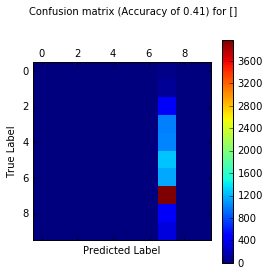

In [66]:
""" Matrice de confusion pour SVM: Accuracy = 0.41  """
""" Faux positifs ou  faux negatifs: 0.59"""
"""  Vrai positifs ou vrai negatifs : 0.41"""

""" Par rapport à la norme .5 : .41 modele peu fiable  """

draw_confusion_matrix(Y_test, svm.predict(X_test), "")

In [67]:
####5.1.2) Random Forest

""" Pour la variable age, on test le modele Random Forest"""

In [68]:
nb_lignes = 10
rf = RandomForest_grid_search(X_train[:nb_lignes], Y_train[:nb_lignes].get_values())

------------------------------ 
 RandomForestClassifier
 best_score_ 0.6 with =  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 


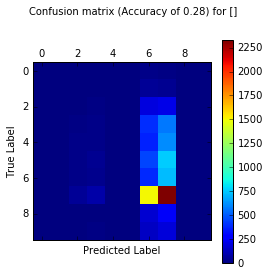

In [69]:
""" Matrice de confusion pour Random Forest: Accuracy = 0.28  """
""" Faux positifs ou  faux negatifs: 0.72"""
"""  Vrai positifs ou vrai negatifs : 0.28"""

""" Par rapport à la norme .5 : .28 modele peu fiable  """
draw_confusion_matrix(Y_test, rf.predict(X_test), "")

In [70]:
####5.1.3) Knn Neighbourg

In [80]:
""" Pour la variable age, on test le modele knn"""
nb_lignes = 10
rf = knn_grid_search(X_train[:nb_lignes], Y_train[:nb_lignes].get_values())

------------------------------ 
 knn_grid_search
{'n_neighbors': [2, 3, 5, 8, 10], 'weights': ['uniform', 'distance'], 'leaf_size': [1, 3], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
Error : [knn_grid_search - 2] : Expected n_neighbors <= n_samples,  but n_samples = 4, n_neighbors = 5


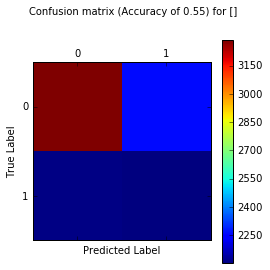

In [87]:
""" Matrice de confusion pour knn"""

""" Matrice de confusion pour Random Forest: Accuracy = 0.55  """
""" Faux positifs ou  faux negatifs: 0.45"""
"""  Vrai positifs ou vrai negatifs : 0.55"""

""" Par rapport à la norme .5 : .55 modele fiable  """
draw_confusion_matrix(Y_test, knn.predict(X_test), "")

In [ ]:
# 5.1.4) SGDClassifier

In [3]:
nb_lignes = 10
sgdc = SGDClassifier_grid_search(X_train[:nb_lignes], Y_train[:nb_lignes].get_values())

NameError: name 'X_train' is not defined

## 5.2) Sex

In [81]:
""" Pour la variable age, on split les données en 4 sous jeu de données, X_train, X_test, Y_train, Y_test"""

X_train, X_test, Y_train, Y_test = train_test_split(X, Y.Sex)

### 5.2.1) Random Forest

In [88]:
""" Test de Random forest pour 100 lignes"""
nb_lignes = 10000
rf = RandomForest_grid_search(X_train[:nb_lignes], Y_train[:nb_lignes])

------------------------------ 
 RandomForestClassifier
 best_score_ 0.7059 with =  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False) 


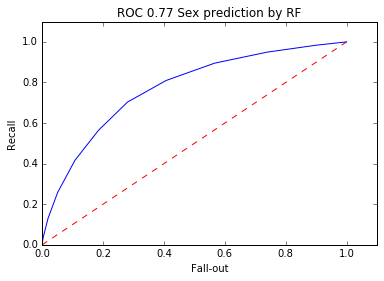

In [89]:
""" .77 pour 100"""
""" supérieur à .5: Très bonne prédiction """
draw_roc_curve(rf, X_test, Y_test, "Sex prediction by RF")

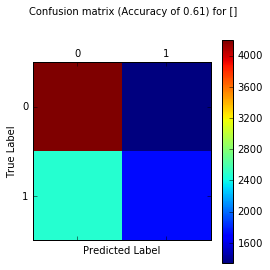

In [38]:
draw_confusion_matrix(Y_test, rf.predict(X_test), "")

 5.2.2) SVM

In [39]:
nb_ligne = 100
svm = svm_grid_search(X_train[:nb_ligne], Y_train[:nb_ligne])

------------------------------ 
 svm_grid_search
 best_score_ = 0.41 with =  SVC(C=1.0, cache_size=10, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=2, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 


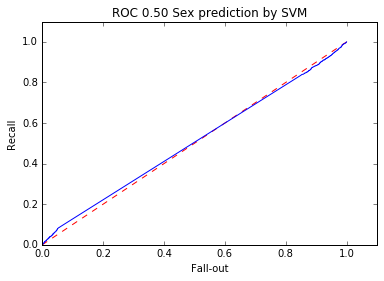

In [40]:
draw_roc_curve(svm, X_test, Y_test, "Sex prediction by SVM")

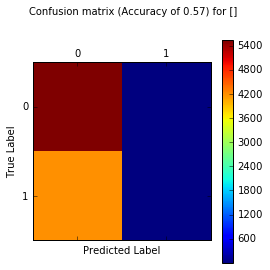

In [41]:
draw_confusion_matrix(Y_test, svm.predict(X_test), "")

#### 5.2.3 Knn neighbourg

In [42]:
#Fonction knn
nb_ligne = 100
knn = knn_grid_search(X_train[:nb_ligne], Y_train[:nb_ligne])


------------------------------ 
 knn_grid_search
{'n_neighbors': [2, 3, 5, 8, 10], 'weights': ['uniform', 'distance'], 'leaf_size': [1, 3], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
 best_score_ = 0.62 with =  KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='distance') 


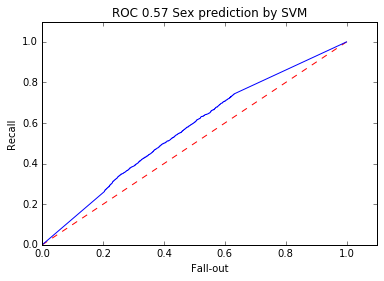

In [43]:
#Roc

""" Score = 0.67 pour 10 lignes > 0.5: bonne prédiction"""
draw_roc_curve(knn, X_test, Y_test, "Sex prediction by SVM")

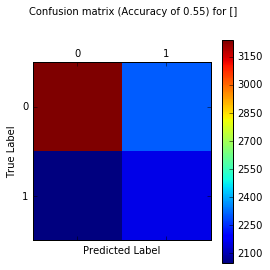

In [44]:
#Matrice de confusion

""" Accracy : 0.55  >.5  : bonne prédiction"""
 
    
draw_confusion_matrix(Y_test, knn.predict(X_test), "")

5.2.4) SGDClassifier

In [82]:

nb_ligne = 10
sgdc = SGDClassifier_grid_search(X_train[:nb_ligne], Y_train[:nb_ligne])

------------------------------ 
 SGD_grid_search
{'penalty': ['l2', 'l1', 'elasticnet'], 'loss': ['log', 'modified_huber', 'loss'], 'n_iter': [2, 5, 8], 'class_weight': [None, 'balanced']}
[SGD_grid_search - 2] : The loss loss is not supported. 
x_train, y_train :         aag.schlau  aag.schlaudanke  adac.aktuelleverkehrslage  \
17788           0                0                          0   
19816           0                0                          0   
34513           0                0                          0   
23777           0                0                          0   
24990           0                0                          0   
24431           0                0                          0   
3492            0                0                          0   
32633           0                0                          0   
30220           0                0                          0   
22797           0                0                          0   
16920           0  

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

In [83]:

#Roc
draw_roc_curve(sgdc, X_test, Y_test, "Sex prediction by SVM")


AttributeError: probability estimates are not available for loss='hinge'

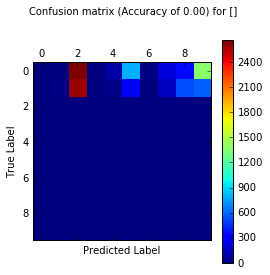

In [84]:
#Matrice de confusion

draw_confusion_matrix(Y_test, sgdc.predict(X_test), "")

#### 7) Commentaire des différents résultats obtenues

L'algorithme SGD est stochastique, il est donc normal dobtenir des résultats différent à chaque lancement"""
Plus globalement:  On a spliter les données au harsard,obtenant par la meme un jeu différent pour chaque split, chaque moment du split et chaque ordinateur, d'ou les différents resultats obtenu ici.